In [1]:
import models
from models import model, create_cd_cluster, cd_diagram
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";budget="used_fidelity"

In [19]:

class bt_plot:
    def __init__(self,slices,rows,dataset,priors):
        self.slices=slices
        self.priors=priors
        self.dataset=dataset.loc[(dataset[budget]>min(item for sublist in self.slices for item in sublist))&(dataset[budget]<=max(item for sublist in self.slices for item in sublist))]
        self.dataset=self.dataset.loc[dataset["prior"].isin(priors)]
        self.df_slices=[]
        def grouper(row):
            for s_n,slice in enumerate(self.slices):
                if row[budget]>slice[0] and row[budget]<=slice[1]:
                    return f"{slice[0]}-{slice[1]}"
        for s_n,slice in enumerate(self.slices):
            self.dataset[f"{budget}_group"]=self.dataset.apply(grouper,axis=1)
            self.df_slices.append(dataset.loc[(dataset[budget]>slice[0])&(dataset[budget]<=slice[1])])
        self.fig, self.axs = plt.subplots(rows, len(self.df_slices), figsize=(4.5*len(self.slices),2*rows))
        plt.close(self.fig)
        self.axs= [self.axs] if rows==1 else self.axs.tolist()
        if len(self.slices)==1:
            self.axs= [[item] for item in self.axs]


    def change_row(self,row:int,lmem_formula:str,globality:bool=False,loss:str="value"):
        if not lmem_formula:
            for cell_n in range(len(self.axs[row])):
                self.axs[row][cell_n].cla()
                autorank_data=convert_to_autorank(self.df_slices[cell_n],value_variable=loss)
                autorank_res=autorank(autorank_data)
                cd_diagram(autorank_res,reverse=False,ax=self.axs[row][cell_n],width=5)
        else:
            if globality:
                post_hocs=model(formula=f"{loss}~{lmem_formula}",data=self.dataset,factor_list=["algorithm",f"{budget}_group"]).post_hoc(marginal_vars=algorithm,grouping_vars=f"{budget}_group")
                for cell_n in range(len(self.axs[row])):
                    self.axs[row][cell_n].cla()
                    post_hoc=(post_hocs[0].loc[post_hocs[0][f"{budget}_group"]==f"{self.slices[cell_n][0]}-{self.slices[cell_n][1]}"],post_hocs[1].loc[post_hocs[1][f"{budget}_group"]==f"{self.slices[cell_n][0]}-{self.slices[cell_n][1]}"])    
                    cd_diagram(post_hoc,reverse=False,ax=self.axs[row][cell_n],width=5)
            else:
                for cell_n in range(len(self.axs[row])):
                    self.axs[row][cell_n].cla()
                    post_hocs=model(formula=f"{loss}~{lmem_formula}",data=self.df_slices[cell_n]).post_hoc(marginal_vars=algorithm)
                    cd_diagram(post_hocs,reverse=False,ax=self.axs[row][cell_n],width=5)
        for cell_n in range(len(self.axs[row])):
            self.axs[row][cell_n].set_title(f"{'Autorank' if not lmem_formula else 'LMEM'} ({loss}) {' (global)' if globality else ''} on slice {self.slices[cell_n]}")
    def show(self):
        return self.fig 

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates


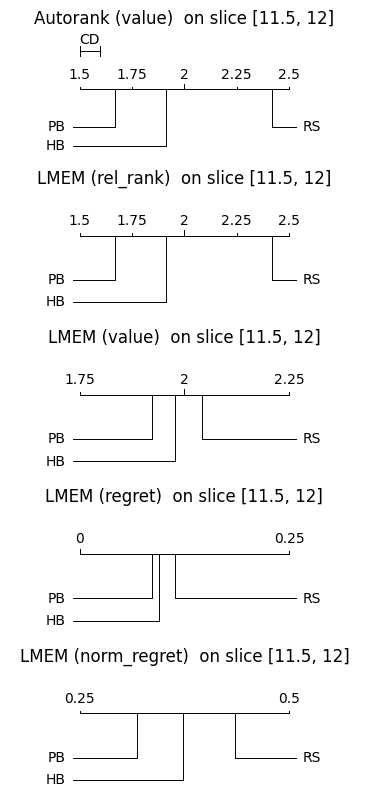

In [20]:
plot_1=bt_plot(slices=[[11.5,12]],rows=5,dataset=get_dataset(dataset_name="fig5_24_at25_bad_intsteps"),priors=["at25","bad"])
plot_1.change_row(0,None,globality=False,loss="value")
plot_1.change_row(1,f"{algorithm}+{budget}+{benchmark}",globality=False,loss="rel_rank")
plot_1.change_row(2,f"{algorithm}+{budget}+{benchmark}",globality=False,loss="value")
plot_1.change_row(3,f"{algorithm}+{budget}+{benchmark}",globality=False,loss="regret")
plot_1.change_row(4,f"{algorithm}+{budget}+{benchmark}",globality=False,loss="norm_regret")
plot_1.show()

c:\Users\Amega\large_files\significance_analysis\.venv_3_10_1\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\large_files\significance_analysis\.venv_3_10_1\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates


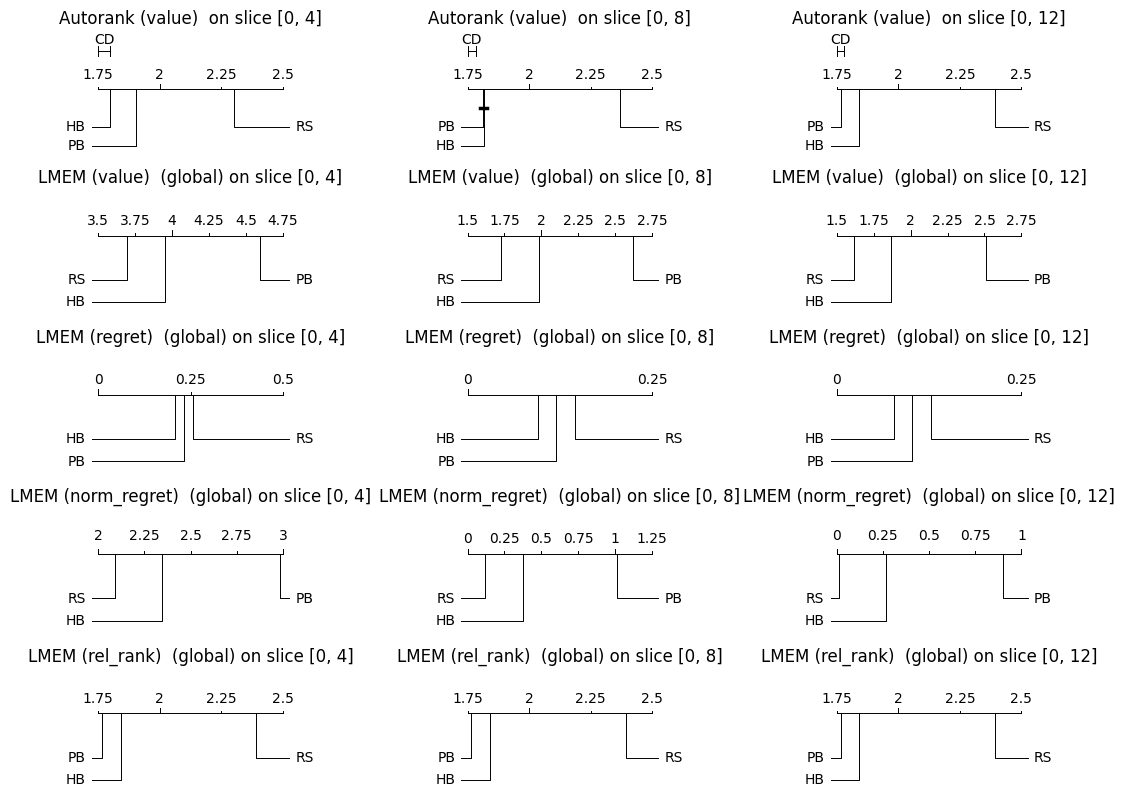

In [21]:
plot_2=bt_plot(slices=[[0,4],[0,8],[0,12]],rows=5,dataset=get_dataset(dataset_name="fig5_24_at25_bad_intsteps"),priors=["at25","bad"])
plot_2.change_row(0,None,globality=False,loss="value")
plot_2.change_row(1,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="value")
plot_2.change_row(2,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="regret")
plot_2.change_row(3,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="norm_regret")
plot_2.change_row(4,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="rel_rank")
plot_2.show()